In [83]:
import geopandas as gpd
import pandas as pd
import requests
import ipywidgets as widgets
import json
from pandas import json_normalize
import folium
from IPython.display import display
#from folium.plugins import MarkerCluster
#from folium import plugins

#-------------------------datas-------------------------
response= requests.get("http://127.0.0.1:5000/measurements")
rawdata=response.text
data=json.loads(rawdata)
df_measurements=pd.json_normalize(data)


df_measurements.sort_values(by='value')

response1=requests.get("http://127.0.0.1:5000/sensor")
rawdata1=response1.text
rawdata1
df1=json.loads(rawdata1)
df1=pd.json_normalize(df1)
df1


gdf_sensor = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lng, df1.lat))
output_path = 'F:\polimi\software engineering\practice\output\prj output\Stations.gpkg'
gdf_sensor.to_file(output_path, driver='GPKG')
target_crs = CRS.from_epsg(4326) 
gdf_sensor.crs = target_crs
print(gdf_sensor.crs)
gdf_sensor


gdf_sen_meas = gdf_sensor.merge(df_measurements, on='sensorid', how='inner')
has_nan = gdf_sen_meas.isna().any().any()
if has_nan:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain any NaN values.")
gdf_sen_meas=gdf_sen_meas.dropna()




EPSG:4326
The DataFrame does not contain any NaN values.


In [85]:

gdf_sen_meas['date'] = pd.to_datetime(gdf_sen_meas['date'], format='%d/%m/%Y %I:%M:%S %p')
unique_weeks = sorted(gdf_sen_meas['date'].dt.week.unique().tolist())
gdfdate= gdf_sen_meas['date'].dt.date
gdf_sen_meas.sort_values(by='date')

town_names = gdf_sen_meas['town'].unique().tolist()

town_search = widgets.Dropdown(
    options=town_names,
    description='Search town:',
    layout=widgets.Layout(width='300px')
)
output = widgets.Output()


week_search = widgets.Dropdown(
    options=unique_weeks,
    description='Search week:',
    layout=widgets.Layout(width='300px')
)
output2 = widgets.Output()

value2=None# Declare values2 as a global variable

def on_search_change(change):
    selected_town = town_search.value
    selected_week = week_search.value

    with output:
        output.clear_output()
        town_data = gdf_sen_meas[gdf_sen_meas['town'] == selected_town]
        values = town_data[town_data['date'].dt.week == selected_week]['value'].tolist()
def on_week_change(change):
    global values2  # Access the global values2 variable
    selected_town = town_search.value
    selected_week = week_search.value

    with output2:
        output2.clear_output()
        town_data = gdf_sen_meas[(gdf_sen_meas['town'] == selected_town) & (gdf_sen_meas['date'].dt.week == selected_week)]
        values2 = town_data['value'].mean()

        print("Selected value:")
        print(values2)

        # Make the request to the API with values2
        response = requests.get(f"http://127.0.0.1:5000/status/{values2}")
        message = response.text
        print("API Response:")
        print(message)

town_search.observe(on_search_change, 'value')
week_search.observe(on_week_change, 'value')

display(town_search, output)
display(week_search, output2)

Dropdown(description='Search town:', layout=Layout(width='300px'), options=('Sondrio', 'Valmadrera', 'San Rocc…

Output()

Dropdown(description='Search week:', layout=Layout(width='300px'), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,…

Output()

In [87]:
town_names = gdf_sen_meas['town'].unique().tolist()
town_search = widgets.Dropdown(
    options=town_names,
    description='Search town:',
    layout=widgets.Layout(width='300px')
)


output = widgets.Output()

def on_search_change(change):
    selected_town = change.new
    with output:
        output.clear_output()
        town_data = gdf_sen_meas[gdf_sen_meas['town'] == selected_town]
        lat = town_data['lng'].mean()
        lon = town_data['lat'].mean()
        value = town_data['value'].mean()

        map= folium.Map(location=[lat.mean(), lon.mean()], zoom_start=12)
        marker = folium.Marker(location=[lat.mean(), lon.mean()],)
        marker.add_to(map)
    

        legend_html = f"""
            <div style="position: fixed; 
                        upper: 50px; left: 50px; width: 150px; height: 80px; 
                        border:2px solid grey; z-index:9999; font-size:14px;
                        background-color:white; opacity: 0.9;
                        ">
                <b>Selected town:</b><br>
                {selected_town}<br>
                <b>Value:</b> {value}
            </div>
        """

        map.get_root().html.add_child(folium.Element(legend_html))

        display(map)

town_search.observe(on_search_change, 'value')

display(town_search)
display(output)

Dropdown(description='Search town:', layout=Layout(width='300px'), options=('Sondrio', 'Valmadrera', 'San Rocc…

Output()

In [88]:
#--------------------moldir--------------------------------------

logged_user_id = None

def get_user(username):
    response = requests.get("http://127.0.0.1:5000/user")
    user_data = response.json()
    for user in user_data:
        if user["name"] == username:
            return user
    return None

def login_user(button):
    global logged_user_id
    status_label.value = "loading"
    username = username_text.value
    user = get_user(username)
    if user is None:
        status_label.value = "Not correct. Try again or create a new user"
    else:
        logged_user_id = user["id"]
        status_label.value = "Success"

def get_logged_user_id():
    return logged_user_id


def register_user(button):
    status_label.value = "loading"
    username = username_text.value
    user = get_user(username)
    if user is None: 
        user_json = {"name": username}
        # Set the Content-Type header to specify JSON
        headers = {"Content-Type": "application/json"}
        # Send a POST request to the server with the JSON payload and headers
        res = requests.post("http://127.0.0.1:5000/user", json=user_json, headers=headers)
        if res.status_code == 201:
            status_label.value = "Sucess. Welcome {}".format(username)
            #id = d.keys(-1)+1
            #d[id]= user
        else:
            status_label.value = "Try again"

    else:
        status_label.value = "Your username aready exists, try loging in. "


# Username Text Input
username_text = widgets.Text(description="Username:")
display(username_text)

# Login Button
login_button = widgets.Button(description="Login")
login_button.on_click(login_user)
display(login_button)

# Register Button
register_button = widgets.Button(description="Register")
register_button.on_click(register_user)
display(register_button)

# Status Label
status_label = widgets.HTML()
display(status_label)




Text(value='', description='Username:')

Button(description='Login', style=ButtonStyle())

Button(description='Register', style=ButtonStyle())

HTML(value='')

In [89]:
#moldir

from geopy.geocoders import Nominatim

geolocator = Nominatim(timeout = 10, user_agent="my-app")
def get_logged_user_id():
    return logged_user_id


# Define a callback function to be called when the button is clicked
def get_geolocation(address):
    location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        return latitude, longitude
    else:
        return None

def get_api_response(latitude, longitude):
    # Replace 'YOUR_API_ENDPOINT' with the actual endpoint of your API
    api_endpoint = 'http://127.0.0.1:5000/sensor/findclose'
    
    # Create a dictionary with the latitude and longitude values
    payload = {"lng": latitude, "lat": longitude, "geom": True}
    
    try:
        # Make a GET request to the API endpoint with the JSON payload
        response = requests.get(api_endpoint, json=payload)
        
        # Check the response status code to ensure the request was successful
        if response.status_code == 200:
            # Process the response data as needed
            api_response = response.json()
            # Return the API response
            return api_response
        else:
            # Handle any errors that occurred during the API request
            print(f"Error: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        # Handle exceptions related to the request
        print(f"Error: {e}")
        return None
    
def button_click(button):
    address = input_text.value
    with output:
        output.clear_output()
        result = get_geolocation(address)
        if result:
            latitude, longitude = result
            #print(f"Latitude: {latitude}, Longitude: {longitude}")
            # Call your API with the obtained coordinates
            api_response = get_api_response(latitude, longitude)
            if api_response:
                # Process the API response as needed
                #print (api_response)
               
            
            # Extract the desired properties from the API response
                properties = api_response.get('properties', {})
                sensor_id = properties.get('sensorid')
                station_name = properties.get('stationname')
                province = properties.get('province')
                town = properties.get('town')
                # Create a folium map centered at the obtained coordinates
                map_center = [latitude, longitude]
                map_zoom = 12
                folium_map = folium.Map(location=map_center, zoom_start=map_zoom)

                # Iterate over the features in the GeoJSON feature collection
                for feature in api_response['features']:
                    # Extract the properties and coordinates from each feature
                    properties = feature['properties']
                    coordinates = feature['geometry']['coordinates']

                    # Create a GeoJSON marker for each feature
                    marker_geojson = {
                        'type': 'Feature',
                        'geometry': {
                            'type': 'Point',
                            'coordinates': coordinates
                        },
                        'properties': {
                            'Title': properties['stationname'],
                            'Description': f"Sensor ID: {properties['sensorid']}\nProvince: {properties['province']}\nTown: {properties['town']}"
                        }
                    }

                    # Add the GeoJSON marker to the folium map
                    folium.GeoJson(
                        json.dumps(marker_geojson),
                        name='marker',
                        style_function=lambda x: {'color': 'red', 'weight': 2, 'fillOpacity': 0.8},
                        tooltip=folium.GeoJsonTooltip(fields=['Title', 'Description'])
                    ).add_to(folium_map)
                    
                     # Calculate bounds for the markers
                marker_bounds = folium_map.get_bounds()

                # Zoom the map to the bounds of the markers
                folium_map.fit_bounds(marker_bounds)
                    
                display (folium_map)
                
                return api_response  # Return the api_response value

            else:
                print("Error occurred during API request.")
        else:
            print("Address not found")

            
def on_button_clicked(b):
    response = button_click(button)  # Call the button_click function and capture the api_response
    # Use the 'response' variable in your another code as needed
    closest_sensor_id = response['features'][0]['properties']['sensorid']
    user_id = get_logged_user_id()
    post_data = {
        'userid': user_id,
        'sensorid': closest_sensor_id
    }
    
    import requests as req
    url = 'http://127.0.0.1:5000/favorites'
    response = req.post(url = url, json = post_data)
    response.status_code
    print("Add favorites")         
            

input_text = widgets.Text(description="Address:")
button = widgets.Button(description="Find nearest station")
output = widgets.Output()

display(input_text, button, output)
button.on_click(button_click)


# Register the callback function to be called when the button is clicked
button1 = widgets.Button(description='Add favorites')
button1.on_click(on_button_clicked)
button1


Text(value='', description='Address:')

Button(description='Find nearest station', style=ButtonStyle())

Output()

Button(description='Add favorites', style=ButtonStyle())

In [90]:
#moldir

api_url = 'http://127.0.0.1:5000/favorites'
user_id = None  # Initialize user_id as None

def get_filtered_data(button):
    global user_id  # Add this line to access the global user_id variable

    # Check if the user is logged in and update user_id
    if logged_user_id is not None:
        user_id = logged_user_id
    else:
        print("User is not logged in.")
        return

    # Send a GET request to the API
    response = requests.get(api_url)

    if response.status_code == 200:
        data = response.json()

        # Filter the data based on the given user_id and remove duplicate sensor_ids
        filtered_data = list({item['sensorid']: item for item in data if item['userid'] == user_id}.keys())

        # Create the list widget with the filtered data
        items = [widgets.Label("Sensorid: " + str(sensor_id)) for sensor_id in filtered_data]
        item_list.children = items

        # Display the list
        item_list.layout.display = "block"
    else:
        print("Failed to retrieve data from the API.")

# Create the button widget
button = widgets.Button(description="Show Favorites")

# Register the click event
button.on_click(get_filtered_data)

# Create an empty list widget to hold the filtered data
item_list = widgets.VBox([])
item_list.layout.display = "none"

# Display the button and list
display(button)
display(item_list)

Button(description='Show Favorites', style=ButtonStyle())

VBox(layout=Layout(display='none'))

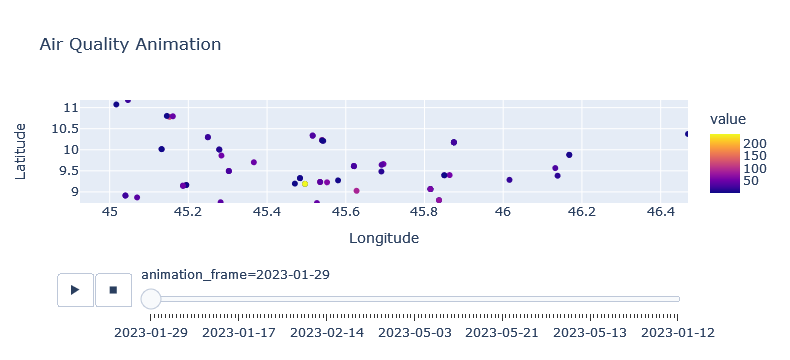

In [91]:
#donya
figan = px.scatter(gdf_sen_meas, x="lng", y="lat", animation_frame=gdfdate, color="value",
                 range_x=[gdf_sen_meas['lng'].min(), gdf_sen_meas['lng'].max()],
                 range_y=[gdf_sen_meas['lat'].min(), gdf_sen_meas['lat'].max()],
                 title="Air Quality Animation")

figan.update_layout(xaxis_title="Longitude", yaxis_title="Latitude")

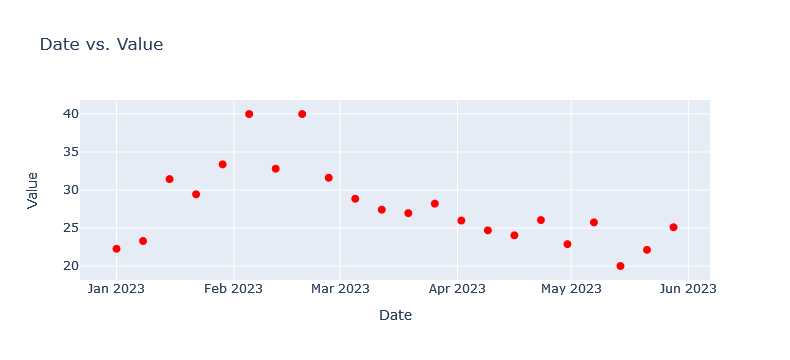

In [92]:
gdfdate= pd.to_datetime(gdfdate)
gdf_sen_meas = gdf_sen_meas.set_index(gdfdate)
gdf_sen_meas.index = pd.DatetimeIndex(gdf_sen_meas.index)
gdf_weekly = gdf_sen_meas.resample('W').mean()
gdf_weekly = gdf_weekly.reset_index()
#----------------------------------------------------------------------------

scatter = go.Scatter(
    x=gdf_weekly['date'],
    y=gdf_weekly['value'],
    mode='markers',
    marker=dict(
        color='red',
        size=8,
        symbol='circle'
    )
)

layout = go.Layout(
    title='Date vs. Value',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
)
fig = go.Figure(data=[scatter], layout=layout)
fig.show()